## Ridge regression with Bag-of-words Top N and added features - hour, review length, price level - Model 02

In [1]:
import gzip
import pandas as pd
import goslate
import json
import requests

import nltk
nltk.download('punkt')
import string
from nltk.stem.porter import *
from nltk.corpus import stopwords
nltk.download("stopwords")
from textblob import TextBlob
from sklearn.metrics import mean_absolute_error,mean_squared_error

from sklearn import linear_model
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anuragthota/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anuragthota/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading Places Data

In [2]:
placesdata = []
with gzip.open("places.clean.json.gz") as f:
    for l in f:
        placesdata.append(eval(l))

In [3]:
len(placesdata), placesdata[:1]

(3114353,
 [{'name': 'Diamond Valley Lake Marina',
   'price': None,
   'address': ['2615 Angler Ave', 'Hemet, CA 92545'],
   'hours': [['Monday', [['6:30 am--4:15 pm']]],
    ['Tuesday', [['6:30 am--4:15 pm']]],
    ['Wednesday', [['6:30 am--4:15 pm']], 1],
    ['Thursday', [['6:30 am--4:15 pm']]],
    ['Friday', [['6:30 am--4:15 pm']]],
    ['Saturday', [['6:30 am--4:15 pm']]],
    ['Sunday', [['6:30 am--4:15 pm']]]],
   'phone': '(951) 926-7201',
   'closed': False,
   'gPlusPlaceId': '104699454385822125632',
   'gps': [33.703804, -117.003209]}])

# Loading Reviews Data

In [4]:
reviewsdata = []
with gzip.open("reviews.clean.json.gz") as file:
    N_revies = [next(file) for x in range(4000000)]

In [5]:
len(N_revies),N_revies[:4]

(4000000,
 [b"{'rating': 3.0, 'reviewerName': u'an lam', 'reviewText': u'Ch\\u1ea5t l\\u01b0\\u1ee3ng t\\u1ea1m \\u1ed5n', 'categories': [u'Gi\\u1ea3i Tr\\xed - Caf\\xe9'], 'gPlusPlaceId': u'108103314380004200232', 'unixReviewTime': 1372686659, 'reviewTime': u'Jul 1, 2013', 'gPlusUserId': u'100000010817154263736'}\n",
  b"{'rating': 5.0, 'reviewerName': u'HAL\\u0130L TURGUT', 'reviewText': u'Wc si temiz duzenli..', 'categories': [u'Turkish Cuisine'], 'gPlusPlaceId': u'102194128241608748649', 'unixReviewTime': 1342870724, 'reviewTime': u'Jul 21, 2012', 'gPlusUserId': u'100000013500285534661'}\n",
  b"{'rating': 5.0, 'reviewerName': u'\\u68ee\\u7530\\u3055\\u3068\\u3053', 'reviewText': u'\\u4f55\\u56de\\u3082\\u79c1\\u306f\\u4e88\\u5b9a\\u306b\\u4f11\\u307f\\u304c\\u30bb\\u30eb\\u30d0\\u306b\\u884c\\u3063\\u305f\\u306e\\u3067\\u899a\\u3048\\u3066\\u898b\\u3066\\u3001\\u5206\\u304b\\u308a\\u307e\\u3059\\u2757', 'categories': [u'Fishing', u'Pond Fish Supplier', u'Seafood Market'], 'gPlusPl

In [6]:
for itr in N_revies:
    reviewsdata.append(eval(itr))


In [7]:
# Printing first three rows of Reviews Data.
reviewsdata[:3], len(reviewsdata)

([{'rating': 3.0,
   'reviewerName': 'an lam',
   'reviewText': 'Chất lượng tạm ổn',
   'categories': ['Giải Trí - Café'],
   'gPlusPlaceId': '108103314380004200232',
   'unixReviewTime': 1372686659,
   'reviewTime': 'Jul 1, 2013',
   'gPlusUserId': '100000010817154263736'},
  {'rating': 5.0,
   'reviewerName': 'HALİL TURGUT',
   'reviewText': 'Wc si temiz duzenli..',
   'categories': ['Turkish Cuisine'],
   'gPlusPlaceId': '102194128241608748649',
   'unixReviewTime': 1342870724,
   'reviewTime': 'Jul 21, 2012',
   'gPlusUserId': '100000013500285534661'},
  {'rating': 5.0,
   'reviewerName': '森田さとこ',
   'reviewText': '何回も私は予定に休みがセルバに行ったので覚えて見て、分かります❗',
   'categories': ['Fishing', 'Pond Fish Supplier', 'Seafood Market'],
   'gPlusPlaceId': '101409858828175402384',
   'unixReviewTime': 1390653513,
   'reviewTime': 'Jan 25, 2014',
   'gPlusUserId': '100000021336848867366'}],
 4000000)

In [8]:
# Converting reviewsdata to pandas DataFrame
init_reviews = pd.DataFrame.from_dict(reviewsdata)


In [10]:
init_reviews.head()

,rating,reviewerName,reviewText,categories,gPlusPlaceId,unixReviewTime,reviewTime,gPlusUserId
0,3.0,an lam,Chất lượng tạm ổn,[Giải Trí - Café],108103314380004200232,1.372687e+09,"Jul 1, 2013",100000010817154263736
1,5.0,HALİL TURGUT,Wc si temiz duzenli..,[Turkish Cuisine],102194128241608748649,1.342871e+09,"Jul 21, 2012",100000013500285534661
2,5.0,森田さとこ,何回も私は予定に休みがセルバに行ったので覚えて見て、分かります❗,"[Fishing, Pond Fish Supplier, Seafood Market]",101409858828175402384,1.390654e+09,"Jan 25, 2014",100000021336848867366
3,5.0,森田さとこ,今度は予定に休みが登米市に行きたい❗☀😅🌌 楽しいに日帰りに登米の見学の観光(*^)(*^-...,[Museum],101477177500158511502,1.389188e+09,"Jan 8, 2014",100000021336848867366
4,4.0,森田さとこ,気仙沼警察署に移転中に絆 👮🐎☺🙋🚓頑張ろう❗,[Police],106994170641063333085,1.390486e+09,"Jan 23, 2014",100000021336848867366


In [11]:
len(init_reviews)

4000000

In [12]:
df_reviews = init_reviews.dropna()

In [13]:
len(df_reviews), df_reviews.iloc[2536747]

(2581631,
 rating                                                            1
 reviewerName                                     Abhijeet Dhamankar
 reviewText        The store manager is extremely rude and has th...
 categories            [Shipping and Mailing, Copy Shop, Print Shop]
 gPlusPlaceId                                  100220547269290934702
 unixReviewTime                                          1.38877e+09
 reviewTime                                              Jan 3, 2014
 gPlusUserId                                   106276733271811926636
 Name: 3930500, dtype: object)

# California Places from Places Data File

In [14]:
# From all non empty gpas and price rows, Getting California places by placing gps coordinates(32.32,42,-124.26,-114.8)
def california_places(places_data):
    location_ca = []
    for itr in places_data:
#         Checking if none or empty gps or price values
        if itr["gps"] != None and itr["gps"] != "" and itr["price"] != None and itr["price"] != "":
            if (
                (itr["gps"][0] >= 32.32)& (itr["gps"][0] <= 42)& (itr["gps"][1] >= -124.26)& (itr["gps"][1] <= -114.8)
            ):
                location_ca.append(itr)
    return location_ca

In [15]:
modified_places = california_places(placesdata)

In [16]:
# Total Instances for clifornia places
len(modified_places)

48865

In [17]:
# Fetching GPS and Price from california places data
GPS = defaultdict(list)
price = defaultdict(list)
places_features = []
for itr in modified_places:
    GPS[itr["gPlusPlaceId"]] = itr["gps"]
    price[itr["gPlusPlaceId"]] = itr["price"]

## Adding Features GPS and Price to Reviews Dataset

In [18]:
def added_features(modified_places, reviews):
    for itr in reviews:
        if itr["gPlusPlaceId"] in GPS:
#   Adding gps to review dataset
            itr["gps"] = GPS[itr["gPlusPlaceId"]]
#     Adding price to revies data
            itr["price"] = price[itr["gPlusPlaceId"]]
            places_features.append(itr)
    return places_features

In [19]:
gps_reviews = added_features(GPS, reviewsdata)

In [20]:
gps_reviews[:1]

[{'rating': 4.0,
  'reviewerName': 'william spindler',
  'reviewText': 'Best War Wanton soup in Red Bluff',
  'categories': ['Asian Restaurant', 'Chinese Restaurant'],
  'gPlusPlaceId': '106591714648856494903',
  'unixReviewTime': 1394669496,
  'reviewTime': 'Mar 12, 2014',
  'gPlusUserId': '100000032416892623125',
  'gps': [40.179159, -122.236162],
  'price': '$$$'}]

## dropping all none and empty values from california data

In [21]:
California_data = []
for d in gps_reviews:
    if (
        d["gps"] != None and d["gps"] != "" and d["price"] != "" and d["price"] != None and d["reviewText"] != ""
        and d["reviewText"] != None and d["categories"] != "" and d["categories"] != None and d["rating"] != None and d["rating"] != ""
    ):
        California_data.append(d)

In [22]:
len(California_data)

76254

In [23]:
# Converting California data to dataset
dfCa_final = pd.DataFrame.from_dict(California_data)

In [24]:
# Adding Review Length to dataset
for i in range(0, len(California_data)):
    California_data[i].update({'reviewLength':len(California_data[i]['reviewText'])})

In [25]:
dfCa_final[:5]

,rating,reviewerName,reviewText,categories,gPlusPlaceId,unixReviewTime,reviewTime,gPlusUserId,gps,price
0,4.0,william spindler,Best War Wanton soup in Red Bluff,"[Asian Restaurant, Chinese Restaurant]",106591714648856494903,1394669496,"Mar 12, 2014",100000032416892623125,"[40.179159, -122.236162]",$$$
1,5.0,william spindler,This is a review that is long overdo. I've bee...,"[European Restaurant, Italian Restaurant, Pizz...",109420033090810328045,1394826388,"Mar 14, 2014",100000032416892623125,"[40.178074, -122.235234]",$$
2,5.0,william spindler,"Long time favorite Mexican food, always consis...",[Mexican Restaurant],115827996910815192564,1394669713,"Mar 12, 2014",100000032416892623125,"[40.175064, -122.242574]",$$
3,5.0,Anne Mason,Great coffee and location! Check out the used ...,"[Espresso Bar, Coffee Shop]",108196901293702895067,1379187049,"Sep 14, 2013",100000106576186066497,"[38.030536, -121.884024]",$$$
4,5.0,Anne Mason,"I've been here dozens of times, and I'll keep ...","[Sushi Restaurant, Asian Restaurant, Japanese ...",111971088396054239194,1394848761,"Mar 14, 2014",100000106576186066497,"[37.961078, -121.748886]",$$


In [26]:
dfCa_final.isnull().values.any()

False

## Data Transformation
 

In [27]:
dfCa_final["dtime"] = pd.to_datetime(dfCa_final["unixReviewTime"], unit="s")
dfCa_final["hour"] = dfCa_final.dtime.dt.hour


In [28]:
review_count = pd.DataFrame(dfCa_final["hour"].value_counts())
review_count["hr"] = review_count.index
review_count.reset_index
review_count = review_count.rename(columns={"hour": "num_reviews"}).sort_values(
    by=["hr"]
)


<Figure size 720x504 with 0 Axes>

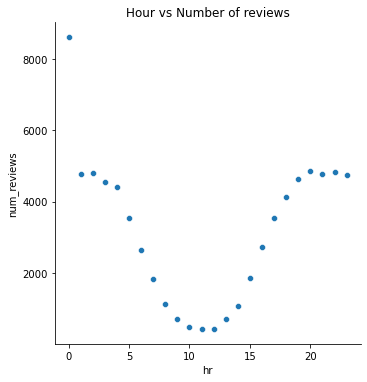

In [31]:
plt.figure(figsize = (10,7))
sns.relplot(x = 'hr', y = 'num_reviews', data = review_count)
plt.title("Hour vs Number of reviews")
plt.show()

In [32]:
for i in range(0, len(California_data)):
    California_data[i].update({'reviewTime':int(datetime.utcfromtimestamp(California_data[i]['unixReviewTime']).strftime('%Y-%m-%d %H:%M:%S')
                                                [11:13])})

### Text Analysis(Bag of Words)

In [33]:
# Extracting bag of words by remving stop words, punctuations and lowering the characters
stop_words = stopwords.words('english')
word_count = defaultdict(int)
top_words = 0
punct = string.punctuation
for d in California_data:
    text = d['reviewText']
    text = text.lower() 
    text = [c for c in text if not (c in punct)] 
    text = ''.join(text) 
    Extr_words = text.strip().split() 
    for w in Extr_words:
        if w not in stop_words:
            top_words += 1
            word_count[w] += 1

In [34]:
len(word_count)

60413

In [35]:
counts=[]
for itr in word_count:
    counts.append((word_count[itr] , itr))

In [36]:
counts.sort(reverse=True)
len(counts),counts[:10]

(60413,
 [(32377, 'food'),
  (23508, 'good'),
  (23220, 'great'),
  (20894, 'place'),
  (18005, 'service'),
  (10467, 'like'),
  (10051, 'best'),
  (9940, 'go'),
  (9939, 'get'),
  (9354, 'one')])

In [37]:
# Fetching top 1500 words.
words = [w[1] for w in counts[:1500]]

In [38]:
wordId = dict(zip(words, range(len(words))))


In [39]:
top_count = set(words)

In [40]:
len(top_count)

1500

### Adding PriceValue to reviews dataset

In [41]:
for i in range(0, len(California_data)):
    California_data[i].update({'priceValue':3 if California_data[i]['price'] == '$$$' else 2 if California_data[i]['price'] == '$$' else 1})

In [42]:
# Spliting data to training validation and test set.
import numpy as np
train, validate, test = np.split(dfCa_final.sample(frac=1), [int(.7*len(dfCa_final)), int(.9*len(dfCa_final))])
training= len(train)
validation=len(validate)
trainingset = California_data[0:training]
validationset = California_data[training : training + validation]
testset = California_data[training + validation :]

len(trainingset), len(validationset), len(testset)

(53377, 15251, 7626)

In [43]:
def Text_Sentiment(data):
    count = [0]*len(top_count)
#     Text Analysis(Bag of Words)
    Review_text = data['reviewText']
    Review_text = Review_text.lower()
    Review_text = [w_count for w_count in Review_text if not (w_count in punct)]
    Review_text = ''.join(Review_text)
    words = Review_text.strip().split()
    for w in words:
        if not (w in top_count): continue
        count[wordId[w]] += 1 
#         Adding length of review, Price Rank, review time(Hour)
    count.append(data['reviewLength'])
    count.append(data['priceValue'])
    count.append(data['reviewTime'])
    count.append(1)
    return count

In [45]:
X = [Text_Sentiment(d) for d in trainingset]
y = [d["rating"] for d in trainingset]
len(X), len(y)

(53377, 53377)

#### Evaluation Metrics

In [46]:
def MSE(predictions, labels):
    error_mse = mean_squared_error(predictions, labels)
    return error_mse
def MAE(predictions, labels):
    error_mae = mean_absolute_error(predictions, labels)
    return error_mae
def RMSE(predictions, labels):
    error_rmse =  np.sqrt(mean_squared_error(predictions, labels))
    return error_rmse

In [67]:
Pred_mse=[]
Pred_mae=[]
Pred_rmse=[]

# Linear Regression

In [69]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X,y)
y_pred = regressor.predict(X)

In [70]:
y_pred[:5]

array([4.19859825, 4.65058448, 4.54155179, 3.83161767, 3.79991595])

In [71]:
validate_X = [Text_Sentiment(d) for d in validationset]
validate_y = [d["rating"] for d in validationset]

test_X = [Text_Sentiment(d) for d in testset]
test_y = [d["rating"] for d in testset]

pred_va = regressor.predict(validate_X)
pred_te = regressor.predict(test_X)

MSE(y_pred,y), MSE(pred_va, validate_y), MSE(pred_te, test_y)
lr_mse=MSE(pred_te, test_y)


In [72]:
MAE(y_pred, y), MAE(pred_va, validate_y), MAE(pred_te, test_y)
lr_mae = MAE(pred_te, test_y)

In [73]:
RMSE(y_pred,y), RMSE(pred_va, validate_y), RMSE(pred_te, test_y)
lr_rmse = RMSE(pred_te, test_y)

In [74]:
Pred_mse.append(lr_mse)
Pred_mae.append(lr_mae)
Pred_rmse.append(lr_rmse)

# Ridge Regression

In [75]:
reg_ridge = linear_model.Ridge(alpha= 1.0, fit_intercept=False)
reg_ridge.fit(X, y)
theta = reg_ridge.coef_
pred = reg_ridge.predict(X)


In [76]:
pred[:5]

array([4.19854644, 4.65133529, 4.54013627, 3.83173048, 3.79956243])

In [77]:
validate_X = [Text_Sentiment(d) for d in validationset]
validate_y = [d["rating"] for d in validationset]

test_X = [Text_Sentiment(d) for d in testset]
test_y = [d["rating"] for d in testset]

pred_va = reg_ridge.predict(validate_X)
pred_te = reg_ridge.predict(test_X)

MSE(pred, y), MSE(pred_va, validate_y), MSE(pred_te, test_y)
rg_mse=MSE(pred_te, test_y)

In [78]:
MAE(pred, y), MAE(pred_va, validate_y), MAE(pred_te, test_y)
rg_mae = MAE(pred_te, test_y)

In [79]:
RMSE(pred, y), RMSE(pred_va, validate_y), RMSE(pred_te, test_y)
rg_rmse=RMSE(pred_te, test_y)

In [80]:
Pred_mse.append(rg_mse)
Pred_mae.append(rg_mae)
Pred_rmse.append(rg_rmse)

# Random Forest Regression

In [81]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 500,max_depth=2, random_state=0)
rf.fit(X,y)
y_rforest = regressor.predict(X)

In [82]:
y_rforest[:5]

array([4.19859825, 4.65058448, 4.54155179, 3.83161767, 3.79991595])

In [83]:
X_va_03 = [Text_Sentiment(d) for d in validationset]
y_va_03 = [d["rating"] for d in validationset]

X_te_03 = [Text_Sentiment(d) for d in testset]
y_te_03 = [d["rating"] for d in testset]

pred_va_03 = rf.predict(X_va_03)
pred_te_03 = rf.predict(X_te_03)

MSE(y_rforest,y), MSE(pred_va_03, y_va_03), MSE(pred_te_03, y_te_03)
rf_mse=MSE(pred_te_03, y_te_03)

In [84]:
MAE(y_rforest,y), MAE(pred_va_03, y_va_03), MAE(pred_te_03, y_te_03)
rf_mae = MAE(pred_te_03, y_te_03)

In [85]:
RMSE(y_rforest,y), RMSE(pred_va_03, y_va_03), RMSE(pred_te_03, y_te_03)
rf_rmse=RMSE(pred_te_03, y_te_03)

In [86]:
Pred_mse.append(rf_mse)
Pred_mae.append(rf_mae)
Pred_rmse.append(rf_rmse)

# MLP Regressor

In [87]:
from sklearn.neural_network import MLPRegressor
regressor_mlp = MLPRegressor(alpha = 0.03, learning_rate_init = 0.04,activation="relu" ,random_state=1, max_iter=600)
regressor_mlp.fit(X,y)
pred_mlp = regressor_mlp.predict(X)

In [88]:
validate_X = [Text_Sentiment(d) for d in validationset]
validate_y = [d["rating"] for d in validationset]

test_X = [Text_Sentiment(d) for d in testset]
test_y = [d["rating"] for d in testset]

pred_va = regressor_mlp.predict(validate_X)
pred_te = regressor_mlp.predict(test_X)

MSE(pred_mlp, y), MSE(pred_va, validate_y), MSE(pred_te, test_y)
ml_mse=MSE(pred_te, test_y)

In [89]:
MAE(pred_mlp, y), MAE(pred_va, validate_y), MAE(pred_te, test_y)
ml_mae = MAE(pred_te, test_y)

In [90]:
RMSE(pred_mlp, y), RMSE(pred_va, validate_y), RMSE(pred_te, test_y)
ml_rmse=RMSE(pred_te, test_y)

In [91]:
Pred_mse.append(ml_mse)
Pred_mae.append(ml_mae)
Pred_rmse.append(ml_rmse)

# LASSO Regression

In [92]:
reg_laso = linear_model.Lasso(0.25, fit_intercept=False)
reg_laso.fit(X,y)
theta1=reg_laso.coef_
pred_la = reg_laso.predict(X)

In [93]:
pred_la[:5]

array([3.8413431 , 3.64910277, 3.13170244, 4.48363538, 3.15970151])

In [94]:
validate_X = [Text_Sentiment(d) for d in validationset]
validate_y = [d["rating"] for d in validationset]

test_X = [Text_Sentiment(d) for d in testset]
test_y = [d["rating"] for d in testset]

pred_va = reg_laso.predict(validate_X)
pred_te = reg_laso.predict(test_X)

MSE(pred_la, y), MSE(pred_va, validate_y), MSE(pred_te, test_y)
la_mse=MSE(pred_te, test_y)

In [95]:
MAE(pred_la, y), MAE(pred_va, validate_y), MAE(pred_te, test_y)
la_mae = MAE(pred_te, test_y)

In [96]:
RMSE(pred_la, y), RMSE(pred_va, validate_y), RMSE(pred_te, test_y)
la_rmse = RMSE(pred_te, test_y)

In [97]:
Pred_mse.append(la_mse)
Pred_mae.append(la_mae)
Pred_rmse.append(la_rmse)

# Gradient Boost Regressor

In [98]:
from sklearn.ensemble import GradientBoostingRegressor
reg_GB = GradientBoostingRegressor(n_estimators=80,min_samples_leaf=1, max_depth=3, min_samples_split=2, max_leaf_nodes=None, max_features=None, learning_rate=0.5, random_state=0).fit(X,y)

pred4 = reg_GB.predict(X)  

In [99]:
pred4[:5]

array([4.41877178, 4.2829137 , 4.57302262, 4.04842685, 3.8328686 ])

In [100]:
validate_X = [Text_Sentiment(d) for d in validationset]
validate_y = [d["rating"] for d in validationset]

test_X = [Text_Sentiment(d) for d in testset]
test_y = [d["rating"] for d in testset]

pred_va = reg_GB.predict(validate_X)
pred_te = reg_GB.predict(test_X)

MSE(pred4, y), MSE(pred_va, validate_y), MSE(pred_te, test_y)
gd_mse=MSE(pred_te, test_y)

In [101]:
MAE(pred4, y), MAE(pred_va, validate_y), MAE(pred_te, test_y)
gd_mae = MAE(pred_te, test_y)

In [102]:
RMSE(pred4, y), RMSE(pred_va, validate_y), RMSE(pred_te, test_y)
gd_rmse = RMSE(pred_te, test_y)

In [103]:
Pred_mse.append(gd_mse)
Pred_mae.append(gd_mae)
Pred_rmse.append(gd_rmse)

In [105]:
Pred_mse

[0.8544630508946826,
 0.8540479628553206,
 1.2883434178474396,
 0.828857597485111,
 1.8026275644431118,
 0.7890713614683961]

In [106]:
Pred_mae

[0.723877377136826,
 0.7237697566993871,
 0.9124838959862915,
 0.7012654303720894,
 1.1161071731968204,
 0.6976633601966022]

In [107]:
alg=['Linear','Ridge','RandomForest','MLP','Lasso','GradientBoost']

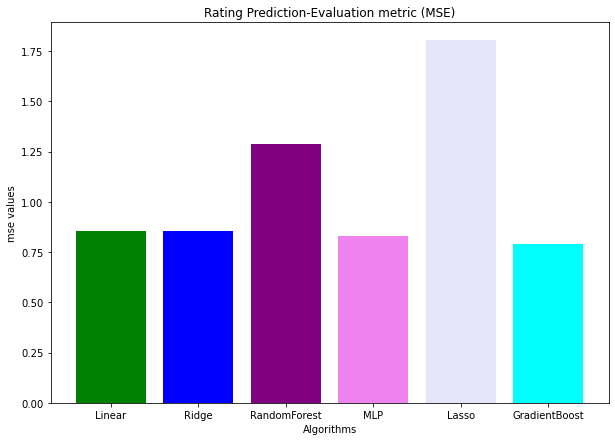

In [108]:
plt.figure(figsize = (10,7))
plt.bar(alg,Pred_mse,color=['green', 'blue', 'purple', 'violet', 'lavender','cyan'])
plt.title("Rating Prediction-Evaluation metric (MSE)")
plt.xlabel("Algorithms")
plt.ylabel("mse values")
plt.show()

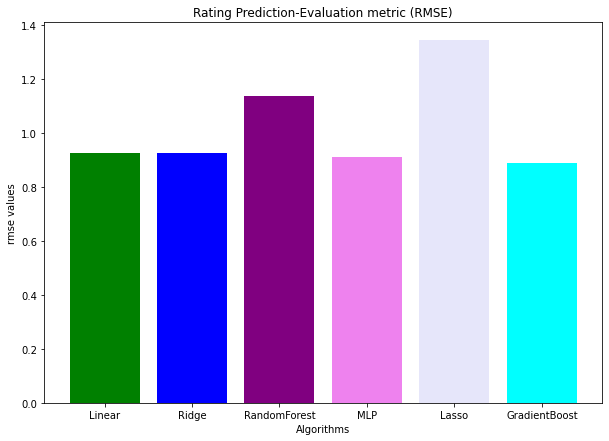

In [112]:
plt.figure(figsize = (10,7))
plt.bar(alg,Pred_rmse,color=['green', 'blue', 'purple', 'violet', 'lavender','cyan'])
plt.title("Rating Prediction-Evaluation metric (RMSE)")
plt.xlabel("Algorithms")
plt.ylabel("rmse values")
plt.show()

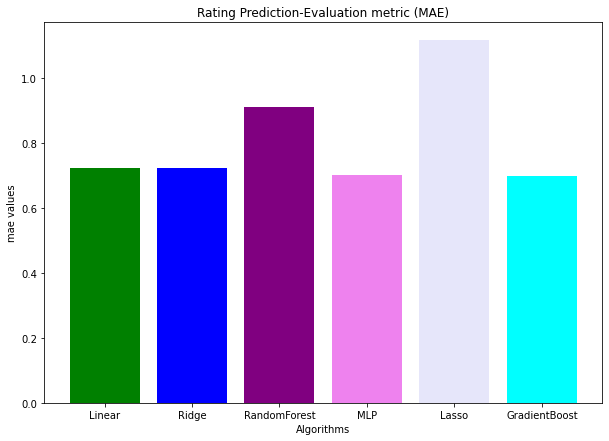

In [111]:
plt.figure(figsize = (10,7))
plt.bar(alg,Pred_mae,color=['green', 'blue', 'purple', 'violet', 'lavender','cyan'])
plt.title("Rating Prediction-Evaluation metric (MAE)")
plt.xlabel("Algorithms")
plt.ylabel("mae values")
plt.show()